# Biological Oceanography (BO)

<img src="Prochlorococcus_marinus.jpeg"/>


This tutorial is part of our Biological Oceanography day. It demonstrates how to do basic analysis and visualization of gridded biological data. We will use A,B,and C data which can be downloaded using CMAP API, a giant data database for Earth system observations and modeling. To download the data using API, please register at CMAP and generate your API key.

### Estimated tutorial time: 1.5 hours

## Tutorial goals

- Python Skills
    - Work with dataframes
    - Make different statistical plots
    - Data co-location
- BO knowledge
    - Learn about global ocean photosynthesis and primary productivity signatures from satellite observations 
    - Understand the vertical distributions of chlorophyll, nutrients, and light availability in the ocean
    - Explore biodiversity and how populations change in different regions of the ocean
    
## Reading 

Brierley, A. S. (2017). Plankton. Current Biology, 27(11), R478-R483. https://www.sciencedirect.com/science/article/pii/S0960982217302154

Armbrust, E. V., & Palumbi, S. R. (2015). Uncovering hidden worlds of ocean biodiversity. Science, 348(6237), 865-867. https://doi.org/10.1126/science.aaa7378

Bristow, L. A., Mohr, W., Ahmerkamp, S., & Kuypers, M. M. (2017). Nutrients that limit growth in the ocean. Current Biology, 27(11), R474-R478. https://www.sciencedirect.com/science/article/pii/S0960982217303287

Tang, W., Llort, J., Weis, J., Perron, M. M., Basart, S., Li, Z., ... & Cassar, N. (2021). Widespread phytoplankton blooms triggered by 2019–2020 Australian wildfires. Nature, 597(7876), 370-375. https://www.nature.com/articles/s41586-021-03805-8

Sala, E., Mayorga, J., Bradley, D. et al. Protecting the global ocean for biodiversity, food and climate. Nature 592, 397–402 (2021). https://doi.org/10.1038/s41586-021-03371-z

# Let's start!

In [1]:
import pandas as pd
import numpy as np
import pycmap
import plotly.express as px

import matplotlib.pyplot as plt

import cartopy.crs as ccrs         # to plot maps with different projections
import cartopy.feature as cfeature # to plot coastlines, land, borders, etc.

#!pip install joypy
from joypy import joyplot          # to make nice-looking ridge plots 


from matplotlib.colors import LogNorm
import xarray as xr

## Chlorophyll A estimates from satellite observations of ocean color

#### Get the API key by registering at simonscmap.com and then going to https://simonscmap.com/apikeymanagement

#### Create a file .cmap_key in your home directory and save your personal API key there as a single line

In [26]:
key =!tail "$HOME/$usr/.cmap_key"    # reading the last line from a file using a system command
api = pycmap.API(token=key[0])       # call api using your unique API key

In [ ]:
modis=api.query(
         '''
         SELECT [time], lat, lon, chl FROM tblCHL_REP 
         WHERE 
         [time] BETWEEN '2016-06-01' AND '2016-06-16' AND 
         lat BETWEEN -90 AND 90 AND 
         lon BETWEEN -180 AND 180
         '''
         ) 
df_rows = pd.DataFrame(modis).set_index(["time",  "lat", "lon"])
ds = xr.Dataset.from_dataframe(df_rows)
chl=ds['chl'].mean('time');

del modis, ds # free some memory by deleting the no longer needed variables.

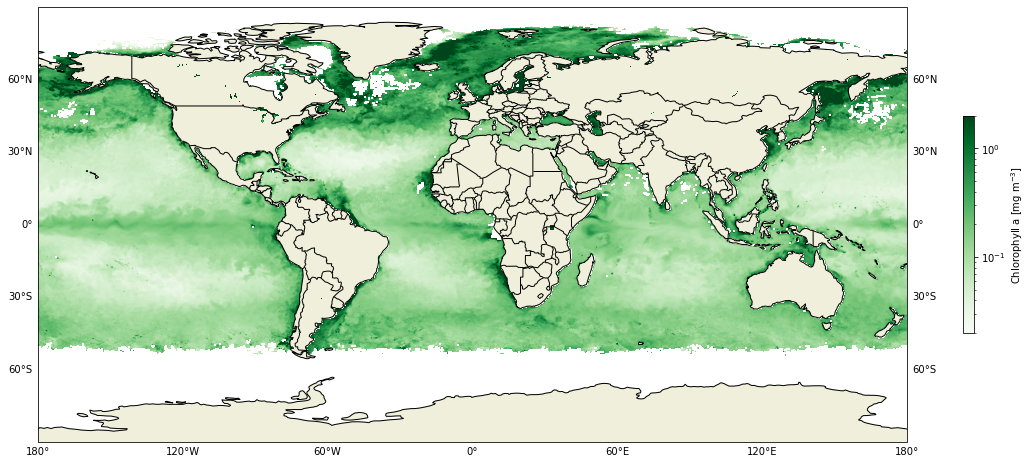

In [21]:
cmap=plt.get_cmap('Greens')

plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree())

gl=ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.xlines=None
gl.ylines=None

im=plt.imshow(chl, 
           cmap=cmap,
           norm=LogNorm(vmin=0.02, vmax=2),
           extent=[-180,180,90,-90])
plt.colorbar(im,shrink=0.5, label='Chlorophyll a [mg m$^{-3}$]')
ax.invert_yaxis()

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS);

## In-class exercise \#1: querry the chlorophyll time series averaged over a region in North Atlantic

Instructions:
 - Follow the "Query" Example \#2 provided by CMAP under Data Retrieval (API) section of the documentation: https://github.com/simonscmap/pycmap#1-data-retrieval-api 
 - Use SQL language for denoting averaged quantities, like AVG(lat) and AVG(chl) 
 - Specify the boundaries of the box: lat BETWEEN 40 AND 50 AND lon BETWEEN -40 AND -20
 - Use SQL language to group and order by time as: GROUP BY [time] and ORDER BY [time] 
 - change the time column to be a proper datetime variable for easy manipulation and cleaner plots: pd.to_datetime(time_variable)
 - make a final plot of chlorophyl concentration averaged within the North Atlantic box.
 - does the chlorophyl concentration vary smoothly or spiky? 


In [77]:
modis_NA=api.query(
         '''
         SELECT [time], AVG(lat) AS lat, AVG(lon) AS lon, AVG(chl) AS chl FROM tblCHL_REP 
         WHERE 
         [time] BETWEEN '2010-06-01' AND '2022-10-01' AND 
         lat BETWEEN 40 AND 50 AND 
         lon BETWEEN -40 AND -20
         GROUP BY [time] 
         ORDER BY [time] 
         '''
         ) 
modis_NA.time=pd.to_datetime(modis_NA.time)

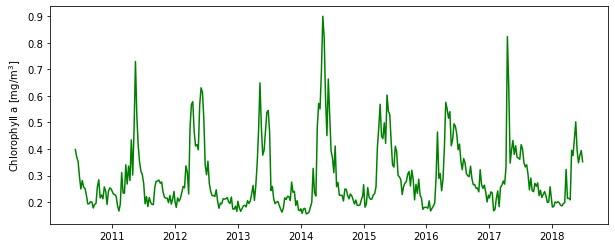

In [79]:
plt.figure(figsize=(10,4))
plt.plot(modis_NA.time, modis_NA.chl,'g');
plt.ylabel('Chlorophyll a [mg/m$^3$]');

### Seaflow dataset

In [5]:
# read in seaflow dataset (surface level- 5m- continuous samples across 50 cruises)
seaflow = api.get_dataset('tblSeaFlow')
print(f'seaflow columns only: {seaflow.columns.values.tolist()}\n')
# can also get with ancilliary data
#seaflow_all = api.get_dataset_with_ancillary("tblSeaFlow")
#print(f'seaflow with ancilliary: {seaflow_all.columns.values.tolist()}')

seaflow columns only: ['time', 'lat', 'lon', 'depth', 'cruise', 'abundance_prochloro', 'abundance_synecho', 'abundance_picoeuk', 'abundance_croco', 'diam_prochloro', 'diam_synecho', 'diam_picoeuk', 'diam_croco', 'Qc_prochloro', 'Qc_synecho', 'Qc_picoeuk', 'Qc_croco', 'biomass_prochloro', 'biomass_synecho', 'biomass_picoeuk', 'biomass_croco']



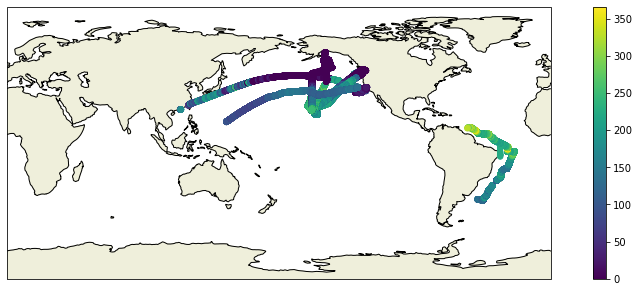

In [13]:
## example plot of prochlorococcus biomass distribution for seaflow
#fig = px.scatter_geo(seaflow, lat='lat',lon='lon',color='abundance_prochloro')
#fig.show()

plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180)); #this specifies which projection to use
ax.set_global();
ax.add_feature(cfeature.COASTLINE);
ax.add_feature(cfeature.LAND);
#ax.add_feature(cfeature.BORDERS);
im=ax.scatter(seaflow['lon'],seaflow['lat'],30,c=seaflow['abundance_prochloro'],transform=ccrs.PlateCarree());
plt.colorbar(im);



### HOT dataset

In [14]:
# read in hawaii ocean time series (HOT) data (1998-2019)
## https://simonscmap.com/catalog/datasets/HOT_PP
HOT = api.get_dataset('tblHOT_PP')
print(f'HOT columns only: {HOT.columns.values.tolist()}\n')
# this dataset also has pre-colcalized ancilliary data
HOT_all = api.get_dataset_with_ancillary("tblHOT_PP")

HOT columns only: ['time', 'lat', 'lon', 'depth', 'cruise_name', 'chl_hot', 'phaeopigments_hot', 'itype', 'light_12_hot', 'dark_12_hot', 'salinity_hot', 'prochlorococcus_hot', 'heterotrophic_bacteria_hot', 'synechococcus_hot', 'eukaryotes_hot']



In [157]:
HOT

time    lat  lon  depth cruise_name  chl_hot  \
0     1988-11-02T00:00:00  22.75 -158     24      HOT001    0.129   
1     1988-11-02T00:00:00  22.75 -158     42      HOT001    0.192   
2     1988-11-02T00:00:00  22.75 -158     68      HOT001    0.285   
3     1988-11-02T00:00:00  22.75 -158    114      HOT001    0.326   
4     1988-12-04T00:00:00  22.75 -158      0      HOT002    0.202   
...                   ...    ...  ...    ...         ...      ...   
2424  2019-12-19T00:00:00  22.75 -158     75      HOT317    0.111   
2425  2019-12-19T00:00:00  22.75 -158    100      HOT317    0.282   
2426  2019-12-19T00:00:00  22.75 -158    125      HOT317    0.169   
2427  2019-12-19T00:00:00  22.75 -158    150      HOT317    0.035   
2428  2019-12-19T00:00:00  22.75 -158    175      HOT317    0.013   

      phaeopigments_hot  itype  light_12_hot  dark_12_hot  salinity_hot  \
0                 0.077      0        12.210          NaN           NaN   
1                 0.051      0         2.470         0.07           NaN   
2                 0.303      0         2.580         0.06           NaN   
3                 0.044      0         0.720         0.16           NaN   
4                 0.000      0           NaN          NaN           NaN   
...                 ...    ...           ...          ...           ...   
2424              0.188      2         3.020          NaN       34.7300   
2425              0.489      2         3.037          NaN       34.7891   
2426              0.374      2         0.560          NaN       34.8342   
2427              0.097      2           NaN          NaN       34.9565   
2428              0.035      2           NaN          NaN       35.0366   

      prochlorococcus_hot  heterotrophic_bacteria_hot  synechococcus_hot  \
0                     NaN                         NaN                NaN   
1                     NaN                         NaN                NaN   
2                     NaN                         NaN                NaN   
3                     NaN                         NaN                NaN   
4                     NaN                         NaN                NaN   
...                   ...                         ...                ...   
2424             191803.0                    392462.0             1612.0   
2425             102670.0                    362702.0              254.0   
2426              55397.0                    273620.0                0.0   
2427               5613.0                    235178.0                0.0   
2428                655.0                    204690.0                0.0   

      eukaryotes_hot  depth_cat  
0                NaN         25  
1                NaN         40  
2                NaN         75  
3                NaN        125  
4                NaN          5  
...              ...        ...  
2424          1295.0         75  
2425          3668.0        100  
2426          1722.0        125  
2427           260.0        150  
2428             0.0        175  

[2429 rows x 16 columns]

### Light attenuation vs lack of nutrients

<img src="Attenuation-of-light-underwater.png" width=400/>


In [17]:
HOT['depth_cat']=np.nan;
HOT.loc[HOT['depth'] < 10, 'depth_cat'] = 5
HOT.loc[(HOT['depth'] > 20) & (HOT['depth'] < 30), 'depth_cat'] = 25
HOT.loc[(HOT['depth'] > 30) & (HOT['depth'] < 50), 'depth_cat'] = 40
HOT.loc[(HOT['depth'] > 50) & (HOT['depth'] < 80), 'depth_cat'] = 75
HOT.loc[(HOT['depth'] > 80) & (HOT['depth'] < 110), 'depth_cat'] = 100
HOT.loc[(HOT['depth'] > 110) & (HOT['depth'] < 130), 'depth_cat'] = 125
HOT.loc[(HOT['depth'] > 130) & (HOT['depth'] < 160), 'depth_cat'] = 150
HOT.loc[(HOT['depth'] > 160) & (HOT['depth'] < 180), 'depth_cat'] = 175

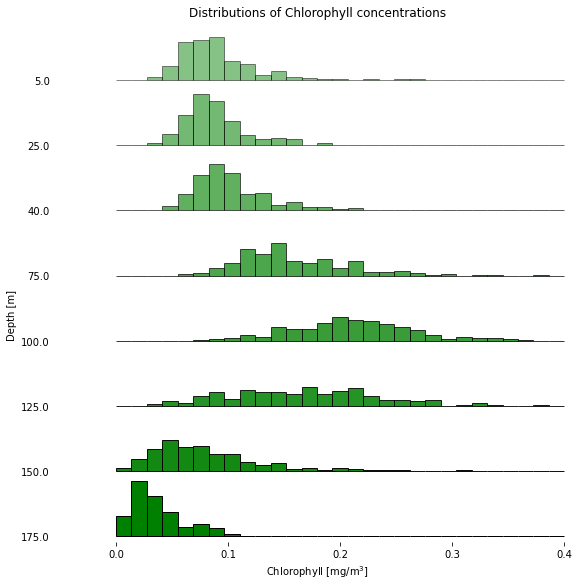

In [61]:
fig, axes = joyplot(HOT, by = 'depth_cat', column = 'chl_hot', 
                    color='Green', fade = True, 
                    title='Distributions of Chlorophyll concentrations',
                    x_range=[-0.05,0.41],
                    hist=True, bins=np.linspace(0, 0.4,30), overlap=0,
                    figsize=(8,8))
axes[-1].set_xlabel('Chlorophyll [mg/m$^3$]') 
axes[4].set_ylabel('Depth [m]') 
plt.savefig('chl_depth.pdf')
plt.show()

## Organisms 

<img src="organisms.png"/>

Armbrust, E. V., & Palumbi, S. R. (2015). Uncovering hidden worlds of ocean biodiversity. Science, 348(6237), 865-867. https://doi.org/10.1126/science.aaa7378

### Data from Flombaum et al 2013

In [20]:
# flowcytometry data that went into Flombaum et al
fl_2013 = api.get_dataset('tblFlombaum')

In [ ]:
# lets look at prochlorococcus abundance above 50 m
fl_surface = fl_2013[fl_2013['depth']>= 50]
pro_min, pro_max = np.min(fl_surface['prochlorococcus_abundance_flombaum']), np.max(fl_surface['prochlorococcus_abundance_flombaum'])
px.scatter_geo(fl_surface, lat='lat',lon='lon',color='prochlorococcus_abundance_flombaum', 
               animation_frame='year', range_color=[pro_min, pro_max])